<a href="https://colab.research.google.com/github/bbebbee/classification_models/blob/main/NEW_Final_fashion_pca_perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion Product Classification using PCA + Perceptron
## Traditional Method with Manual Feature Selection

### 1. Import Libraries

In [1]:
# Cell 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import zipfile
import warnings
warnings.filterwarnings('ignore')

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.linear_model import Perceptron, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

### 2. Setup Kaggle API and Download Dataset

In [3]:
!pip install -q kaggle

In [4]:
!mkdir -p ~/.kaggle
from google.colab import files
print('Please upload your kaggle.json file')
uploaded = files.upload()

Please upload your kaggle.json file


Saving kaggle.json to kaggle.json


In [5]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
print('Kaggle API configured!')

Kaggle API configured!


In [6]:
import kagglehub
import pandas as pd
import os
from PIL import Image
import numpy as np

# Download dataset
path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-dataset")
print("Path to dataset files:", path)

# หา path ที่ถูกต้อง
print("\nChecking directory structure...")
!ls -la {path}

# ลองหา CSV และ images folder
if os.path.exists(f"{path}/fashion-dataset/styles.csv"):
    csv_path = f"{path}/fashion-dataset/styles.csv"
    images_path = f"{path}/fashion-dataset/images"
elif os.path.exists(f"{path}/styles.csv"):
    csv_path = f"{path}/styles.csv"
    images_path = f"{path}/images"
else:
    print("Looking for CSV file...")
    !find {path} -name "styles.csv"

print(f"\nCSV Path: {csv_path}")
print(f"Images Path: {images_path}")
print(f"Images folder exists: {os.path.exists(images_path)}")

# Load CSV
df = pd.read_csv(csv_path, on_bad_lines='skip')
print(f'\nTotal data: {len(df)}')
df.head()

Using Colab cache for faster access to the 'fashion-product-images-dataset' dataset.
Path to dataset files: /kaggle/input/fashion-product-images-dataset

Checking directory structure...
total 4
drwxr-sr-x 3 1000 1000    0 Dec  3 12:36 .
drwxr-xr-x 3 root root 4096 Dec  4 15:12 ..
drwxr-sr-x 5 1000 1000    0 Dec  3 12:34 fashion-dataset

CSV Path: /kaggle/input/fashion-product-images-dataset/fashion-dataset/styles.csv
Images Path: /kaggle/input/fashion-product-images-dataset/fashion-dataset/images
Images folder exists: True

Total data: 44424


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


### 3. Load and Explore Data

In [7]:
df = pd.read_csv(csv_path, engine='python', on_bad_lines='skip')
print(f'Total data: {len(df)}')
df.head()

Total data: 44424


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [8]:
print('SubCategory distribution:')
print(df['subCategory'].value_counts())

SubCategory distribution:
subCategory
Topwear                     15402
Shoes                        7343
Bags                         3055
Bottomwear                   2694
Watches                      2542
Innerwear                    1808
Jewellery                    1079
Eyewear                      1073
Fragrance                    1011
Sandal                        963
Wallets                       933
Flip Flops                    913
Belts                         811
Socks                         698
Lips                          527
Dress                         478
Loungewear and Nightwear      470
Saree                         427
Nails                         329
Makeup                        307
Headwear                      293
Ties                          258
Accessories                   129
Scarves                       118
Cufflinks                     108
Apparel Set                   106
Free Gifts                    104
Stoles                         90
Skin Care 

### 4. Select Top 5 Classes

In [9]:
top_5_classes = df['subCategory'].value_counts().head(5).index.tolist()
print(f'Top 5 classes: {top_5_classes}')

df_filtered = df[df['subCategory'].isin(top_5_classes)].copy()
print(f'\nFiltered data: {len(df_filtered)}')

df_filtered = df_filtered.groupby('subCategory').sample(n = 1000, random_state = 101)
print(df_filtered['subCategory'].value_counts())

Top 5 classes: ['Topwear', 'Shoes', 'Bags', 'Bottomwear', 'Watches']

Filtered data: 31036
subCategory
Bags          1000
Bottomwear    1000
Shoes         1000
Topwear       1000
Watches       1000
Name: count, dtype: int64


### 5. Load Images and Prepare Data

In [10]:
IMAGE_SIZE = (64, 64)

def load_image(image_id, size=IMAGE_SIZE):
    try:
        img_path = os.path.join(images_path, f'{image_id}.jpg')
        img = Image.open(img_path).convert('L')
        img = img.resize(size)
        return np.array(img)
    except:
        return None

In [11]:
print('Loading images...')
X_list = []
y_list = []

for idx, row in df_filtered.iterrows():
    img = load_image(row['id'])
    if img is not None:
        X_list.append(img.flatten())
        y_list.append(row['subCategory'])

    if len(X_list) % 1000 == 0:
        print(f'Loaded {len(X_list)} images...')

X = np.array(X_list)
y = np.array(y_list)

print(f'\nTotal loaded images: {len(X)}')
print(f'Image shape: {X.shape}')
print(f'Labels shape: {y.shape}')

Loading images...
Loaded 1000 images...
Loaded 2000 images...
Loaded 3000 images...
Loaded 4000 images...
Loaded 5000 images...

Total loaded images: 5000
Image shape: (5000, 4096)
Labels shape: (5000,)


In [12]:
print('Class distribution in loaded data:')
unique, counts = np.unique(y, return_counts=True)
for label, count in zip(unique, counts):
    print(f'{label}: {count}')

Class distribution in loaded data:
Bags: 1000
Bottomwear: 1000
Shoes: 1000
Topwear: 1000
Watches: 1000


### 6. Encode Labels

In [13]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print('Label mapping:')
for i, label in enumerate(label_encoder.classes_):
    print(f'{i}: {label}')

Label mapping:
0: Bags
1: Bottomwear
2: Shoes
3: Topwear
4: Watches


### 7. Train-Test Split

In [14]:
# Cell 9: Train-Validation-Test Split
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=101, stratify=y_encoded
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=101, stratify=y_temp
)

print(f'Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)')
print(f'Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)')
print(f'Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)')
print(f'Total: {X_train.shape[0] + X_val.shape[0] + X_test.shape[0]} samples')

Training set: 3200 samples (64.0%)
Validation set: 800 samples (16.0%)
Test set: 1000 samples (20.0%)
Total: 5000 samples


### 8. Normalize Data

In [15]:
# Cell 10: Normalize Data
X_train_normalized = X_train.astype(np.float32) / 255.0
X_val_normalized = X_val.astype(np.float32) / 255.0
X_test_normalized = X_test.astype(np.float32) / 255.0

print('Data normalized to [0, 1] range')

Data normalized to [0, 1] range


### 9. Standardize Data (Important for PCA)

In [16]:
# Cell 11: Standardize Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_normalized)
X_val_scaled = scaler.transform(X_val_normalized)
X_test_scaled = scaler.transform(X_test_normalized)

print('Data standardized (mean=0, std=1)')

Data standardized (mean=0, std=1)


## GridSearch

In [17]:
# Cell 12: Grid Search for Best Parameters
print('Running Grid Search to find best parameters...')
print('This may take 10-20 minutes...\n')

param_grid = {
    'pca__n_components': [50, 100, 150, 200],
    'perceptron__max_iter': [500, 1000, 1500],
    'perceptron__eta0': [0.001, 0.01, 0.1],
    'perceptron__tol': [1e-3, 1e-4]
}

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(random_state=101)),
    ('perceptron', Perceptron(random_state=101))
])

X_train_val = np.vstack([X_train_normalized, X_val_normalized])
y_train_val = np.concatenate([y_train, y_val])

val_fold = np.concatenate([
    np.full(len(X_train_normalized), -1),
    np.zeros(len(X_val_normalized))
])

ps = PredefinedSplit(val_fold)

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=ps,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_val, y_train_val)

print('\n' + '='*60)
print('GRID SEARCH RESULTS')
print('='*60)
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best validation score: {grid_search.best_score_:.4f}')

best_model = grid_search.best_estimator_
y_test_pred_grid = best_model.predict(X_test_normalized)
test_accuracy_grid = accuracy_score(y_test, y_test_pred_grid)
print(f'Test accuracy with best params: {test_accuracy_grid:.4f}')
print('='*60)

results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values('rank_test_score')
print('\nTop 5 parameter combinations:')
top_results = results_df[['params', 'mean_test_score', 'std_test_score']].head()
for idx, row in top_results.iterrows():
    print(f"\n{row['params']}")
    print(f"  Validation Accuracy: {row['mean_test_score']:.4f} (+/- {row['std_test_score']:.4f})")

best_n_components = grid_search.best_params_['pca__n_components']
best_max_iter = grid_search.best_params_['perceptron__max_iter']
best_eta0 = grid_search.best_params_['perceptron__eta0']
best_tol = grid_search.best_params_['perceptron__tol']

print(f'\nBest parameters to use:')
print(f'  PCA components: {best_n_components}')
print(f'  Max iterations: {best_max_iter}')
print(f'  Learning rate (eta0): {best_eta0}')
print(f'  Tolerance: {best_tol}')

Running Grid Search to find best parameters...
This may take 10-20 minutes...

Fitting 1 folds for each of 72 candidates, totalling 72 fits

GRID SEARCH RESULTS
Best parameters: {'pca__n_components': 150, 'perceptron__eta0': 0.001, 'perceptron__max_iter': 500, 'perceptron__tol': 0.001}
Best validation score: 0.9513
Test accuracy with best params: 0.9460

Top 5 parameter combinations:

{'pca__n_components': 150, 'perceptron__eta0': 0.1, 'perceptron__max_iter': 500, 'perceptron__tol': 0.001}
  Validation Accuracy: 0.9513 (+/- 0.0000)

{'pca__n_components': 150, 'perceptron__eta0': 0.1, 'perceptron__max_iter': 500, 'perceptron__tol': 0.0001}
  Validation Accuracy: 0.9513 (+/- 0.0000)

{'pca__n_components': 150, 'perceptron__eta0': 0.1, 'perceptron__max_iter': 1000, 'perceptron__tol': 0.001}
  Validation Accuracy: 0.9513 (+/- 0.0000)

{'pca__n_components': 150, 'perceptron__eta0': 0.1, 'perceptron__max_iter': 1000, 'perceptron__tol': 0.0001}
  Validation Accuracy: 0.9513 (+/- 0.0000)

{'pc

Training with loss tracking...
Epoch  10 | Train Loss: 0.0491, Val Loss: 0.0700 | Train Acc: 0.9509, Val Acc: 0.9300
Epoch  20 | Train Loss: 0.0328, Val Loss: 0.0600 | Train Acc: 0.9672, Val Acc: 0.9400
Epoch  30 | Train Loss: 0.0356, Val Loss: 0.0613 | Train Acc: 0.9644, Val Acc: 0.9387
Epoch  40 | Train Loss: 0.0341, Val Loss: 0.0600 | Train Acc: 0.9659, Val Acc: 0.9400
Epoch  50 | Train Loss: 0.0325, Val Loss: 0.0613 | Train Acc: 0.9675, Val Acc: 0.9387
Epoch  60 | Train Loss: 0.0306, Val Loss: 0.0587 | Train Acc: 0.9694, Val Acc: 0.9413
Epoch  70 | Train Loss: 0.0337, Val Loss: 0.0613 | Train Acc: 0.9663, Val Acc: 0.9387
Epoch  80 | Train Loss: 0.0244, Val Loss: 0.0600 | Train Acc: 0.9756, Val Acc: 0.9400
Epoch  90 | Train Loss: 0.0281, Val Loss: 0.0537 | Train Acc: 0.9719, Val Acc: 0.9463
Epoch 100 | Train Loss: 0.0275, Val Loss: 0.0587 | Train Acc: 0.9725, Val Acc: 0.9413


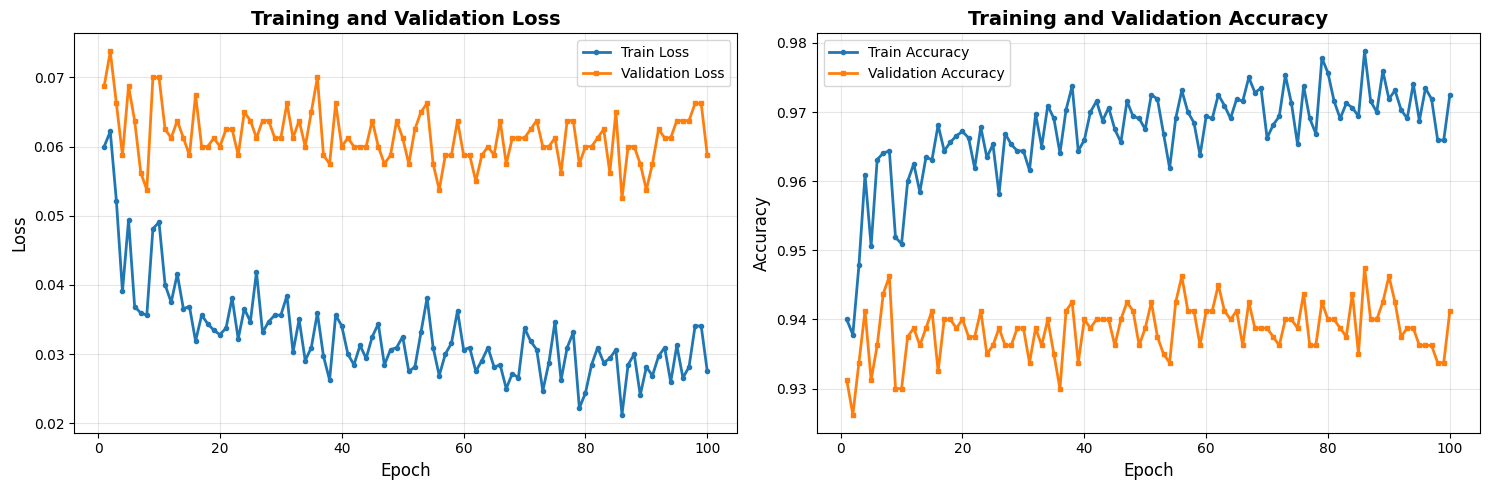


TRAINING SUMMARY
Final Train Loss: 0.0275
Final Validation Loss: 0.0587
Final Train Accuracy: 0.9725
Final Validation Accuracy: 0.9413


In [18]:
# Cell: Training with Loss Tracking
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt

print('Training with loss tracking...')

# ต้อง apply PCA ก่อน
pca_temp = PCA(n_components=best_n_components, random_state=101)
X_train_pca_temp = pca_temp.fit_transform(X_train_scaled)
X_val_pca_temp = pca_temp.transform(X_val_scaled)

# ใช้ SGDClassifier แทน Perceptron
sgd = SGDClassifier(
    loss='perceptron',
    max_iter=1,
    tol=None,
    random_state=101,
    learning_rate='constant',
    eta0=best_eta0,
    warm_start=True
)

train_losses = []
val_losses = []
train_accs = []
val_accs = []
epochs_list = []

n_epochs = 100

for epoch in range(n_epochs):
    sgd.fit(X_train_pca_temp, y_train)

    train_acc = sgd.score(X_train_pca_temp, y_train)
    val_acc = sgd.score(X_val_pca_temp, y_val)

    # ใช้ 1-accuracy เป็น loss (ง่ายกว่า)
    train_loss = 1 - train_acc
    val_loss = 1 - val_acc

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    epochs_list.append(epoch + 1)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1:3d} | Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

# Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(epochs_list, train_losses, label='Train Loss', linewidth=2, marker='o', markersize=3)
axes[0].plot(epochs_list, val_losses, label='Validation Loss', linewidth=2, marker='s', markersize=3)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(epochs_list, train_accs, label='Train Accuracy', linewidth=2, marker='o', markersize=3)
axes[1].plot(epochs_list, val_accs, label='Validation Accuracy', linewidth=2, marker='s', markersize=3)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('\n' + '='*60)
print('TRAINING SUMMARY')
print('='*60)
print(f'Final Train Loss: {train_losses[-1]:.4f}')
print(f'Final Validation Loss: {val_losses[-1]:.4f}')
print(f'Final Train Accuracy: {train_accs[-1]:.4f}')
print(f'Final Validation Accuracy: {val_accs[-1]:.4f}')
print('='*60)

### 10. Apply PCA for Feature Extraction

In [19]:
# Cell 13: Apply PCA with Best Parameters
print(f'Applying PCA with {best_n_components} components...')

pca = PCA(n_components=best_n_components, random_state=101)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f'Original features: {X_train_scaled.shape[1]}')
print(f'PCA features: {X_train_pca.shape[1]}')
print(f'Explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}')

Applying PCA with 150 components...
Original features: 4096
PCA features: 150
Explained variance ratio: 0.9075


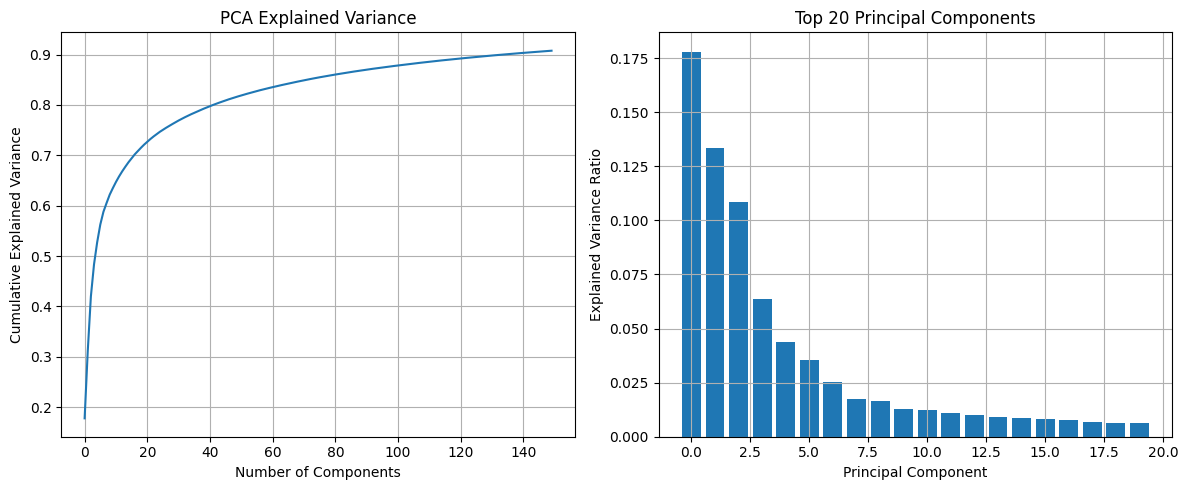

In [20]:
# Cell 14: Plot PCA Variance
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.bar(range(min(20, best_n_components)), pca.explained_variance_ratio_[:20])
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Top 20 Principal Components')
plt.grid(True)

plt.tight_layout()
plt.show()

### 11. Train Perceptron Classifier

In [21]:
# Cell 15: Train Perceptron with Best Parameters
print(f'Training with best parameters from Grid Search...')

perceptron = Perceptron(
    max_iter=best_max_iter,
    eta0=best_eta0,
    tol=best_tol,
    random_state=101
)
perceptron.fit(X_train_pca, y_train)

print('Perceptron training complete!')

Training with best parameters from Grid Search...
Perceptron training complete!


### 12. Make Predictions

In [22]:
# Cell 16: Make Predictions
y_train_pred = perceptron.predict(X_train_pca)
y_val_pred = perceptron.predict(X_val_pca)
y_test_pred = perceptron.predict(X_test_pca)

train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Training Accuracy: 0.9666
Validation Accuracy: 0.9513
Test Accuracy: 0.9560


### 13. Detailed Classification Report

In [23]:
# Cell 17: Classification Report
print('Classification Report (Test Set):')
print('='*60)
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

Classification Report (Test Set):
              precision    recall  f1-score   support

        Bags       0.95      0.96      0.96       200
  Bottomwear       0.97      0.89      0.93       200
       Shoes       0.99      0.99      0.99       200
     Topwear       0.91      0.97      0.94       200
     Watches       0.97      0.96      0.97       200

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000



### 14. Confusion Matrix

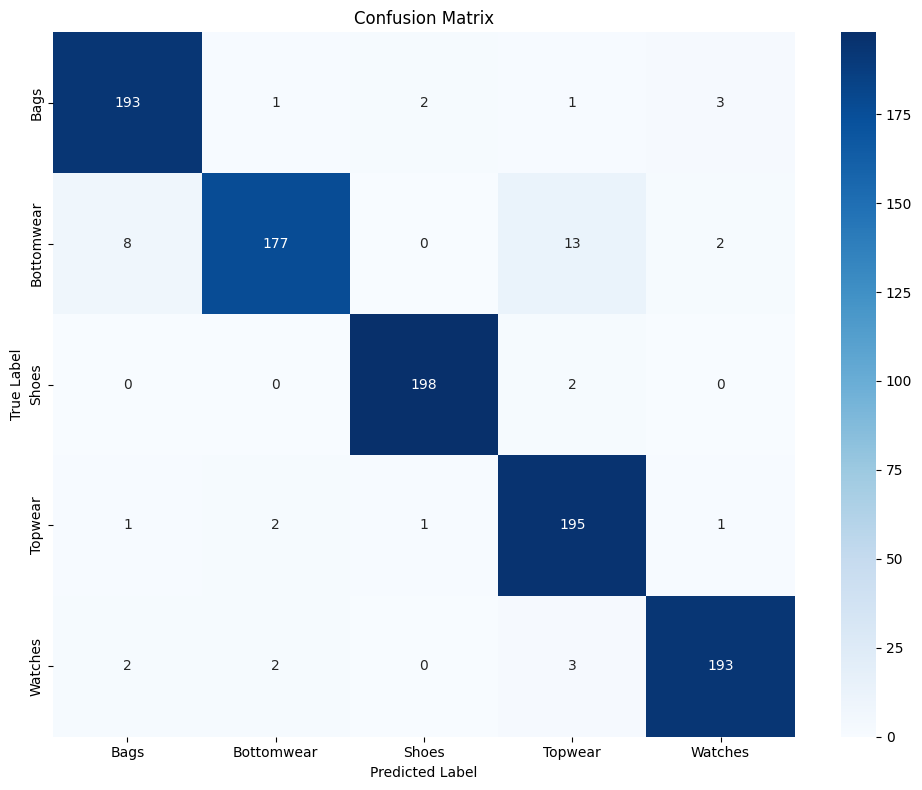

In [24]:
# Cell 18: Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### 15. Experiment with Different PCA Components

Components: 50, Train Acc: 0.9403, Test Acc: 0.9320
Components: 100, Train Acc: 0.9659, Test Acc: 0.9520
Components: 150, Train Acc: 0.9666, Test Acc: 0.9560
Components: 200, Train Acc: 0.9616, Test Acc: 0.9480
Components: 300, Train Acc: 0.9666, Test Acc: 0.9550


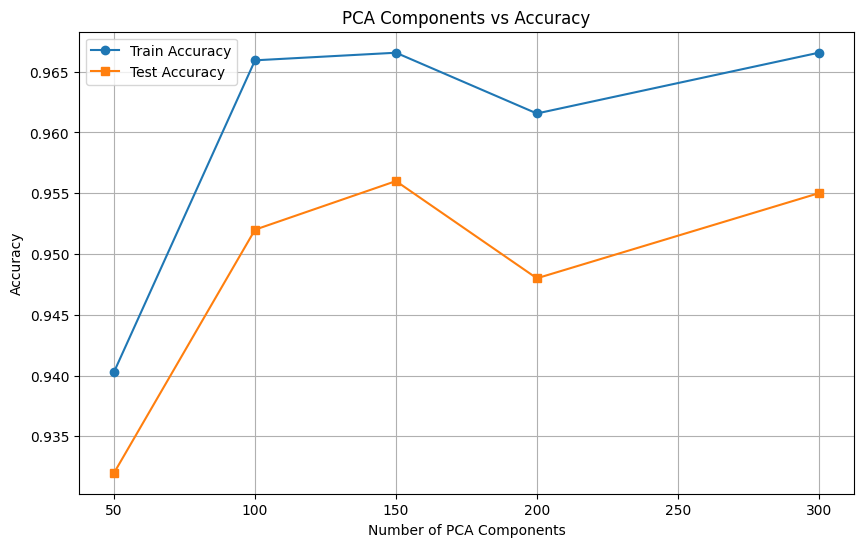

In [25]:
# Cell 19: Experiment with Different PCA Components
pca_components = [50, 100, 150, 200, 300]
train_accuracies = []
test_accuracies = []

for n_comp in pca_components:
    pca_temp = PCA(n_components=n_comp, random_state=101)
    X_train_temp = pca_temp.fit_transform(X_train_scaled)
    X_test_temp = pca_temp.transform(X_test_scaled)

    model_temp = Perceptron(max_iter=1000, tol=1e-3, random_state=101)
    model_temp.fit(X_train_temp, y_train)

    train_acc = accuracy_score(y_train, model_temp.predict(X_train_temp))
    test_acc = accuracy_score(y_test, model_temp.predict(X_test_temp))

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f'Components: {n_comp}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

plt.figure(figsize=(10, 6))
plt.plot(pca_components, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(pca_components, test_accuracies, marker='s', label='Test Accuracy')
plt.xlabel('Number of PCA Components')
plt.ylabel('Accuracy')
plt.title('PCA Components vs Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### 16. Visualize Sample Predictions

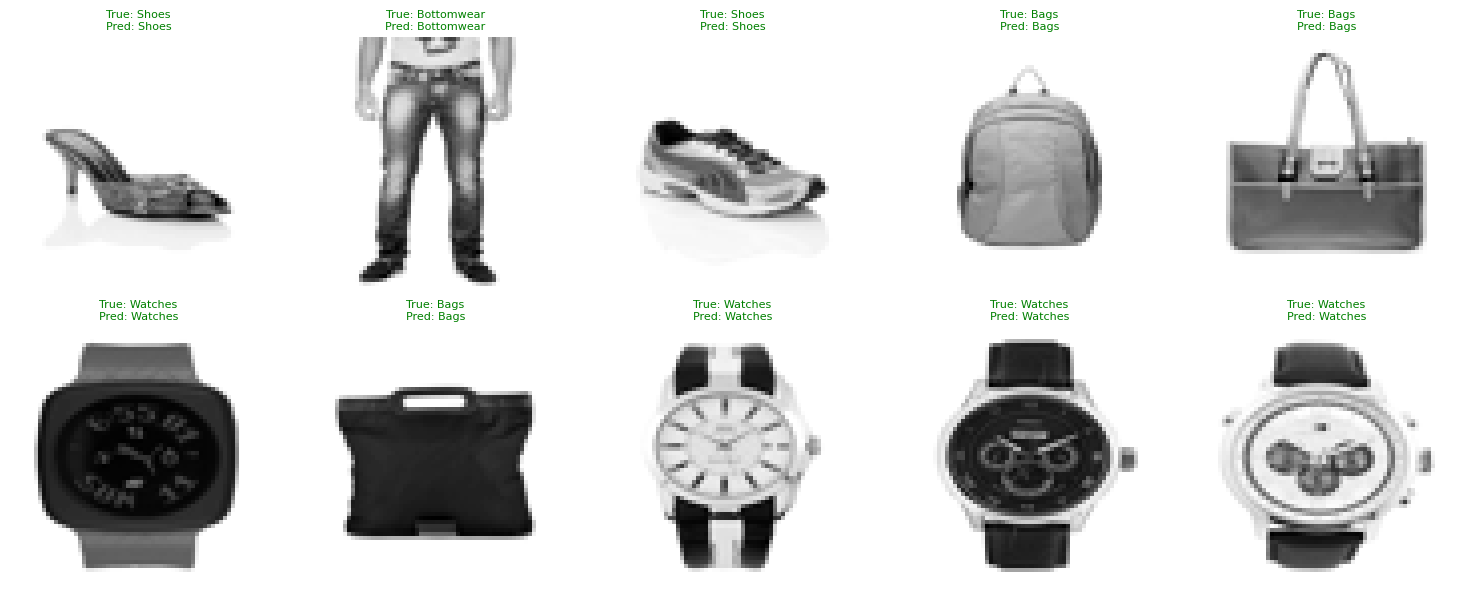

In [26]:
# Cell 20: Visualize Sample Predictions
n_samples = 10
sample_indices = np.random.choice(len(X_test), n_samples, replace=False)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i, idx in enumerate(sample_indices):
    img = X_test[idx].reshape(IMAGE_SIZE)
    true_label = label_encoder.classes_[y_test[idx]]
    pred_label = label_encoder.classes_[y_test_pred[idx]]

    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')

    color = 'green' if true_label == pred_label else 'red'
    axes[i].set_title(f'True: {true_label}\nPred: {pred_label}', color=color, fontsize=8)

plt.tight_layout()
plt.show()

Training with loss tracking...
Epoch 10, Train: 0.9597, Val: 0.9413, Test: 0.9490
Epoch 20, Train: 0.9556, Val: 0.9263, Test: 0.9440
Epoch 30, Train: 0.9691, Val: 0.9437, Test: 0.9620
Epoch 40, Train: 0.9656, Val: 0.9325, Test: 0.9530
Epoch 50, Train: 0.9709, Val: 0.9375, Test: 0.9540
Epoch 60, Train: 0.9706, Val: 0.9387, Test: 0.9610
Epoch 70, Train: 0.9719, Val: 0.9375, Test: 0.9560
Epoch 80, Train: 0.9628, Val: 0.9337, Test: 0.9470
Epoch 90, Train: 0.9722, Val: 0.9387, Test: 0.9560
Epoch 100, Train: 0.9634, Val: 0.9325, Test: 0.9530


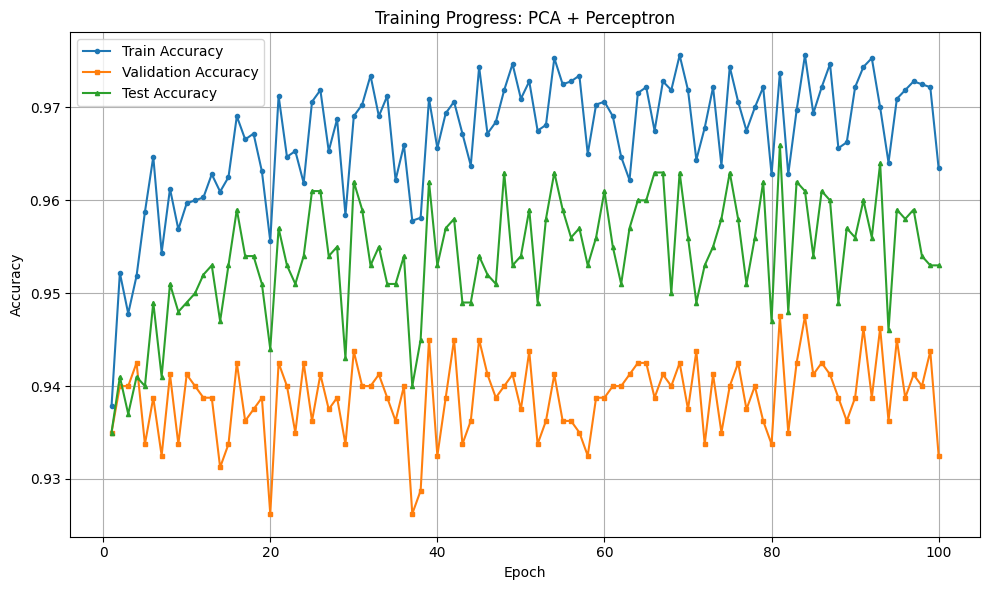


Final Train Accuracy: 0.9634
Final Validation Accuracy: 0.9325
Final Test Accuracy: 0.9530


In [27]:
# Cell 21: Training Progress with Loss Tracking
print('Training with loss tracking...')

sgd = SGDClassifier(
    loss='perceptron',
    max_iter=1,
    tol=None,
    random_state=101,
    learning_rate='constant',
    eta0=0.01,
    warm_start=True
)

train_accs = []
val_accs = []
test_accs = []
epochs_list = []

for epoch in range(100):
    sgd.fit(X_train_pca, y_train)

    train_acc = sgd.score(X_train_pca, y_train)
    val_acc = sgd.score(X_val_pca, y_val)
    test_acc = sgd.score(X_test_pca, y_test)

    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)
    epochs_list.append(epoch + 1)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

plt.figure(figsize=(10, 6))
plt.plot(epochs_list, train_accs, label='Train Accuracy', marker='o', markersize=3)
plt.plot(epochs_list, val_accs, label='Validation Accuracy', marker='s', markersize=3)
plt.plot(epochs_list, test_accs, label='Test Accuracy', marker='^', markersize=3)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Progress: PCA + Perceptron')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f'\nFinal Train Accuracy: {train_accs[-1]:.4f}')
print(f'Final Validation Accuracy: {val_accs[-1]:.4f}')
print(f'Final Test Accuracy: {test_accs[-1]:.4f}')

### 17. Summary

In [28]:
# Cell 22: Summary
print('='*60)
print('SUMMARY')
print('='*60)
print(f'Method: PCA + Perceptron (Traditional ML)')
print(f'Number of classes: {len(label_encoder.classes_)}')
print(f'Classes: {list(label_encoder.classes_)}')
print(f'Image size: {IMAGE_SIZE}')
print(f'Original features: {X_train.shape[1]}')
print(f'PCA components: {best_n_components}')
print(f'Explained variance: {pca.explained_variance_ratio_.sum():.4f}')
print(f'Training samples: {X_train.shape[0]}')
print(f'Validation samples: {X_val.shape[0]}')
print(f'Test samples: {X_test.shape[0]}')
print(f'Training accuracy: {train_accuracy:.4f}')
print(f'Validation accuracy: {val_accuracy:.4f}')
print(f'Test accuracy: {test_accuracy:.4f}')
print('='*60)
print('\nBest Hyperparameters from Grid Search:')
print(f'  PCA components: {best_n_components}')
print(f'  Max iterations: {best_max_iter}')
print(f'  Learning rate (eta0): {best_eta0}')
print(f'  Tolerance: {best_tol}')
print('='*60)

SUMMARY
Method: PCA + Perceptron (Traditional ML)
Number of classes: 5
Classes: [np.str_('Bags'), np.str_('Bottomwear'), np.str_('Shoes'), np.str_('Topwear'), np.str_('Watches')]
Image size: (64, 64)
Original features: 4096
PCA components: 150
Explained variance: 0.9075
Training samples: 3200
Validation samples: 800
Test samples: 1000
Training accuracy: 0.9666
Validation accuracy: 0.9513
Test accuracy: 0.9560

Best Hyperparameters from Grid Search:
  PCA components: 150
  Max iterations: 500
  Learning rate (eta0): 0.001
  Tolerance: 0.001


# Try with real photo

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
BATCH PREDICTION - ALL IMAGES IN FOLDER

📂 Found 21 images in: /content/drive/MyDrive/Test images/


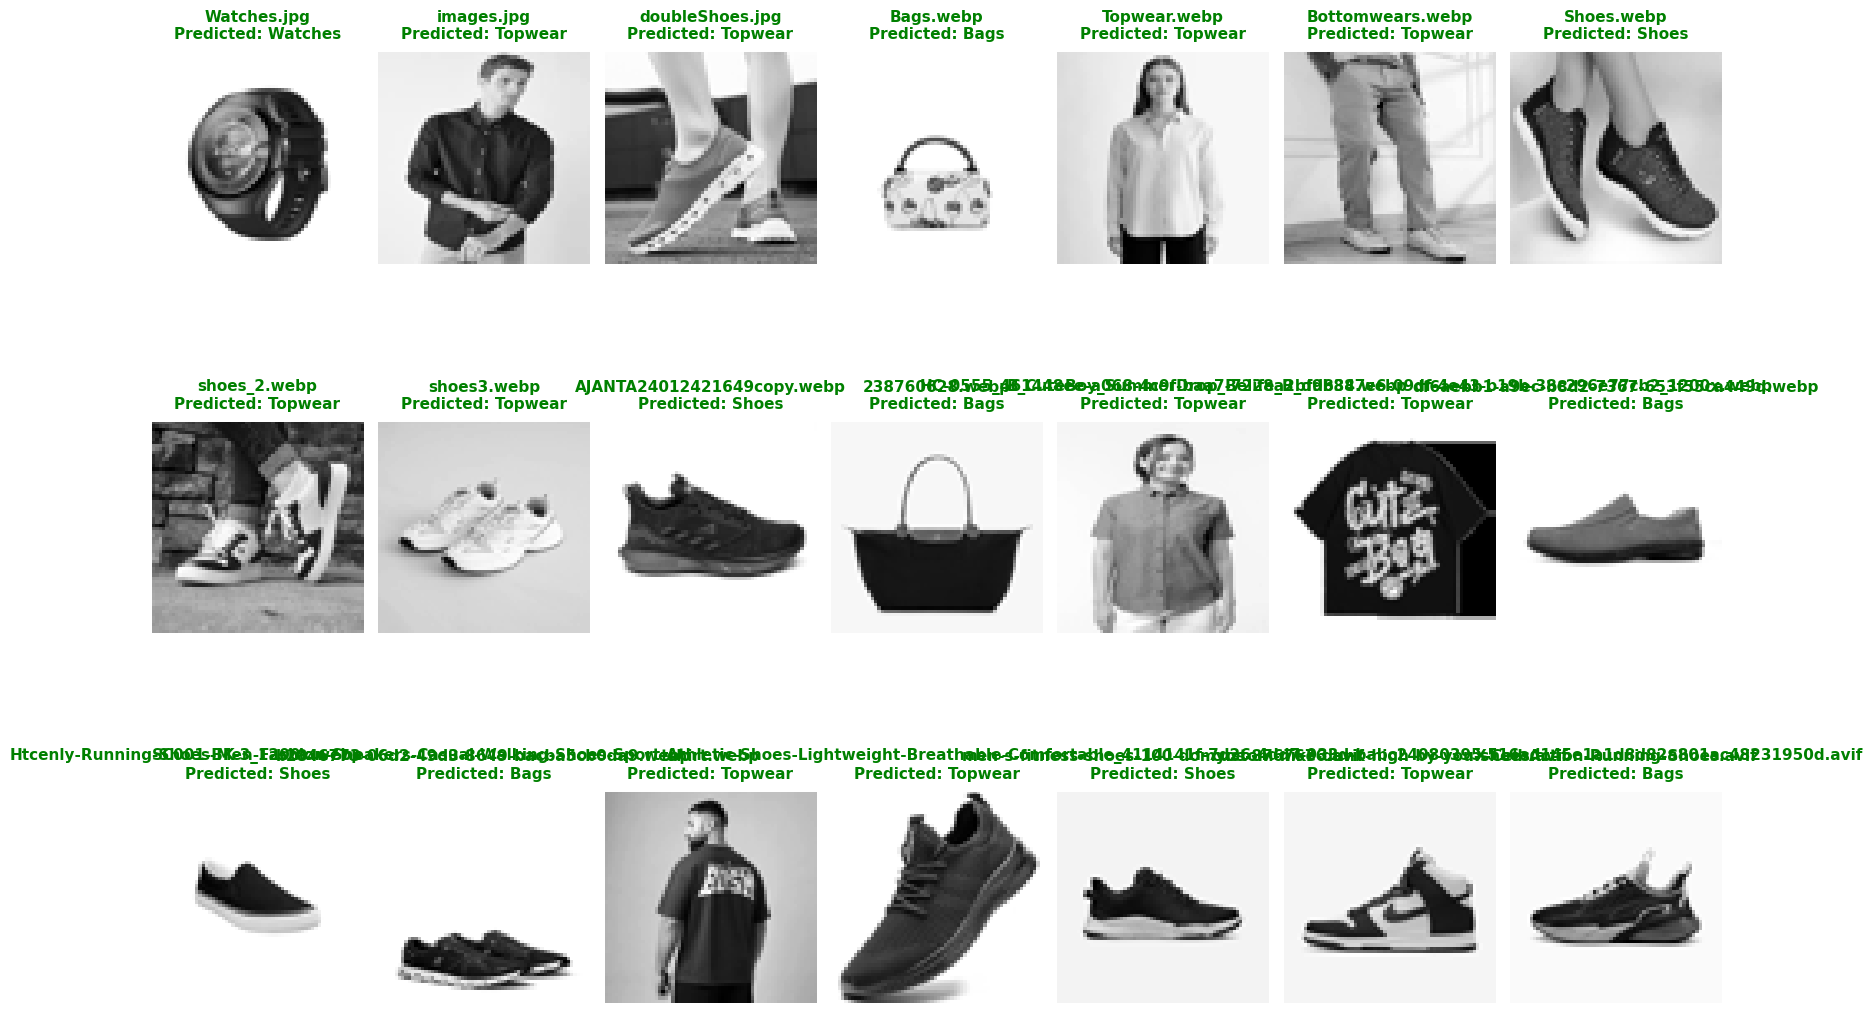


PREDICTION SUMMARY

📊 Predictions by Class:
   Watches        : 1 images
   Topwear        : 11 images
   Bags           : 5 images
   Shoes          : 4 images

📝 Detailed Results:
   Watches.jpg                    → Watches
   images.jpg                     → Topwear
   doubleShoes.jpg                → Topwear
   Bags.webp                      → Bags
   Topwear.webp                   → Topwear
   Bottomwears.webp               → Topwear
   Shoes.webp                     → Shoes
   shoes_2.webp                   → Topwear
   shoes3.webp                    → Topwear
   AJANTA24012421649copy.webp     → Shoes
   238760628.webp                 → Bags
   HC-0555_461448ee-a068-4c9f-baa7-7228a2bfd834.webp → Topwear
   B_CuteBoy_SummerDrop_Belife_B_d9b887e6-09df-4e43-b19b-38c296e77cb2_1200x.webp → Topwear
   df6aebb1-a9ec-b8d2-7367-653f55ca449d.webp → Bags
   SC001-BK-3_1200x.webp          → Shoes
   b2846773-06d2-49d3-8649-bacba5cb0da9.webp → Bags
   tshirt.webp                    → Topwear

In [40]:
# Cell 23: Predict All Images - Larger Display
from google.colab import drive
from PIL import Image
import os
import glob

# Mount Drive
drive.mount('/content/drive')

print('='*60)
print('BATCH PREDICTION - ALL IMAGES IN FOLDER')
print('='*60)

# ระบุ folder
folder_path = '/content/drive/MyDrive/Test images/'

# หารูปทั้งหมดใน folder
image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG', '*.webp', '*avif']
image_files = []
for ext in image_extensions:
    image_files.extend(glob.glob(os.path.join(folder_path, ext)))

print(f'\n📂 Found {len(image_files)} images in: {folder_path}')

if len(image_files) == 0:
    print('❌ No images found!')
else:
    results = []

    # Process all images
    for img_path in image_files:
        try:
            img = Image.open(img_path).convert('L')
            img_resized = img.resize((64, 64))

            img_array = np.array(img_resized).flatten()
            img_normalized = img_array.astype(np.float32) / 255.0
            img_scaled = scaler.transform([img_normalized])
            img_pca = pca.transform(img_scaled)

            prediction = perceptron.predict(img_pca)[0]
            predicted_class = label_encoder.classes_[prediction]

            results.append({
                'filename': os.path.basename(img_path),
                'prediction': predicted_class,
                'image': img_resized
            })

        except Exception as e:
            print(f'❌ Error: {e}')

    # Display all images
    n_images = len(results)
    cols = 7  # 7 รูปต่อแถว
    rows = (n_images + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(16, rows*4))

    if n_images == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for idx, result in enumerate(results):
        axes[idx].imshow(result['image'], cmap='gray')

        # สีของ title
        color = 'green'
        axes[idx].set_title(f"{result['filename']}\nPredicted: {result['prediction']}",
                           fontsize=11, fontweight='bold', color=color, pad=10)
        axes[idx].axis('off')

    # ซ่อน subplot ว่าง
    for idx in range(n_images, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

    # Summary
    print('\n' + '='*60)
    print('PREDICTION SUMMARY')
    print('='*60)

    # นับจำนวนแต่ละ class
    from collections import Counter
    predictions_count = Counter([r['prediction'] for r in results])

    print('\n📊 Predictions by Class:')
    for cls, count in predictions_count.items():
        print(f'   {cls:15s}: {count} images')

    print('\n📝 Detailed Results:')
    for result in results:
        print(f"   {result['filename']:30s} → {result['prediction']}")

    print('='*60)
    print(f'\n✅ Successfully processed {len(results)}/{len(image_files)} images!')

INTERACTIVE PREDICTION DEMO

Choose your upload method:
1. Upload from local computer
2. Use image from Google Drive

Enter your choice (1 or 2): 1

📁 Upload from local computer...


Saving IMG_9418 (1).jpg to IMG_9418 (1) (1).jpg

Processing: IMG_9418 (1) (1).jpg


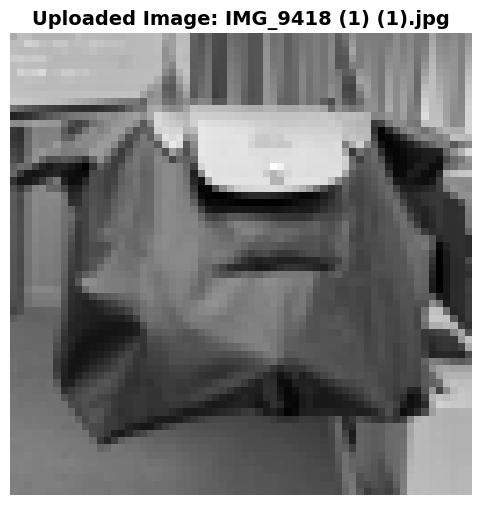


PREDICTION RESULTS

🎯 Predicted Class: Topwear
   Label Index: 3

📊 Decision Function Scores (confidence-like):
------------------------------------------------------------
👉 Topwear        :  86.147 ███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

In [34]:
# Cell 23: Interactive Prediction Demo - Upload from Drive or Local
from google.colab import files
from PIL import Image
import io
import os

print('='*60)
print('INTERACTIVE PREDICTION DEMO')
print('='*60)
print('\nChoose your upload method:')
print('1. Upload from local computer')
print('2. Use image from Google Drive')
print('='*60)

choice = input('\nEnter your choice (1 or 2): ')

uploaded = {}

if choice == '1':
    print('\n📁 Upload from local computer...')
    uploaded = files.upload()

elif choice == '2':
    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    print('\n📂 Enter the path to your image in Google Drive')
    print('Example: /content/drive/MyDrive/images/test.jpg')
    img_path = input('Image path: ')

    if os.path.exists(img_path):
        filename = os.path.basename(img_path)
        with open(img_path, 'rb') as f:
            uploaded[filename] = f.read()
        print(f'✅ Loaded: {filename}')
    else:
        print(f'❌ File not found: {img_path}')
else:
    print('❌ Invalid choice!')

# Process uploaded images
for filename in uploaded.keys():
    print(f'\n{"="*60}')
    print(f'Processing: {filename}')
    print('='*60)

    # Load and preprocess image
    img_bytes = uploaded[filename]
    img = Image.open(io.BytesIO(img_bytes)).convert('L')
    img_resized = img.resize((64, 64))

    # Display original image
    plt.figure(figsize=(6, 6))
    plt.imshow(img_resized, cmap='gray')
    plt.title(f'Uploaded Image: {filename}', fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.show()

    # Prepare for prediction
    img_array = np.array(img_resized).flatten()
    img_normalized = img_array.astype(np.float32) / 255.0
    img_scaled = scaler.transform([img_normalized])
    img_pca = pca.transform(img_scaled)

    # Predict
    prediction = perceptron.predict(img_pca)[0]
    predicted_class = label_encoder.classes_[prediction]

    # Get decision function scores
    decision_scores = perceptron.decision_function(img_pca)[0]

    # Display results
    print('\n' + '='*60)
    print('PREDICTION RESULTS')
    print('='*60)
    print(f'\n🎯 Predicted Class: {predicted_class}')
    print(f'   Label Index: {prediction}')
    print('\n📊 Decision Function Scores (confidence-like):')
    print('-'*60)

    # Sort by score
    scores_sorted = sorted(zip(label_encoder.classes_, decision_scores),
                          key=lambda x: x[1], reverse=True)

    for cls, score in scores_sorted:
        bar = '█' * int(abs(score) * 10) if score > 0 else ''
        marker = '👉' if cls == predicted_class else '  '
        print(f'{marker} {cls:15s}: {score:7.3f} {bar}')

    print('='*60)

print('\n✅ Prediction complete!')